# ColorDescriptor

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import math
from IPython.core.pylabtools import figsize
figsize(16, 12)
from cyvlfeat.kmeans import kmeans
from scipy.spatial import distance

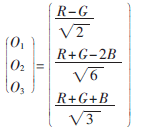

In [2]:
img = cv2.imread('../testTrainingDataMix/1802late86.jpg')
b,g,r = cv2.split(img)
O_1 = (r-g)/math.sqrt(2)
O_2 = (r+g-2*b)/math.sqrt(6)
O_3 = (r+g+b)/math.sqrt(3)
O_1 = cv2.normalize(O_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
O_2 = cv2.normalize(O_2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
O_3 = cv2.normalize(O_3, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

In [3]:
# O_1 = r
# O_2 = g
# O_3 = b
# O_1 = cv2.normalize(O_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
# O_2 = cv2.normalize(O_2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
# O_3 = cv2.normalize(O_3, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

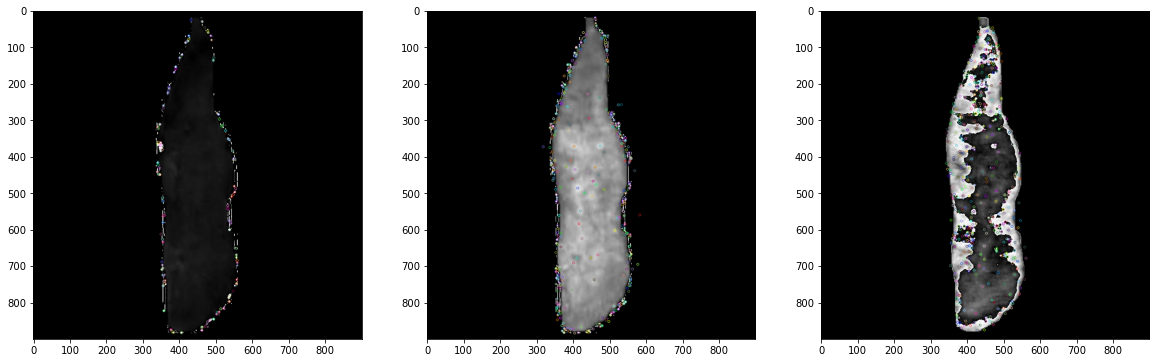

In [4]:
def sift_kp(image):
#     gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d_SIFT.create()
    kp,des = sift.detectAndCompute(image, None)
    kp_image = cv2.drawKeypoints(image, kp, None)
    return kp_image,kp,des
kp_image1,kp1, des1 = sift_kp(O_1)
kp_image2,kp2, des2 = sift_kp(O_2)
kp_image3,kp3, des3 = sift_kp(O_3)
plt.figure(figsize = (20,16))
plt.subplot(131)
plt.imshow(cv2.cvtColor(kp_image1,cv2.COLOR_BGR2RGB))
plt.subplot(132)
plt.imshow(cv2.cvtColor(kp_image2,cv2.COLOR_BGR2RGB))
plt.subplot(133)
plt.imshow(cv2.cvtColor(kp_image3,cv2.COLOR_BGR2RGB))

In [5]:
print(len(kp1))
print(len(kp2))
print(len(kp3))

187
488
662


In [6]:
des1_pad = np.pad(des1,((0,0),(0,256)),'constant',constant_values = (0,0))
des2_pad = np.pad(des2,((0,0),(128,128)),'constant',constant_values = (0,0)) 
des3_pad = np.pad(des3,((0,0),(256,0)),'constant',constant_values = (0,0)) 
descriptors = np.vstack((des1_pad,des2_pad,des3_pad))
descriptors.shape

(1337, 384)

In [7]:
! rm ./testTrainingDataMix/.DS_Store

rm: ./testTrainingDataMix/.DS_Store: No such file or directory


In [8]:
def get_clusters(inputDir, cluster_size):
    bag_of_features = []
    for (path,dirname,filenames) in os.walk(inputDir):
        for imageName in filenames: 
#             print(imageName)
            img = cv2.imread(inputDir+imageName)
            b,g,r = cv2.split(img)
            O_1 = (r-g)/math.sqrt(2)
            O_2 = (r+g-2*b)/math.sqrt(6)
            O_3 = (r+g+b)/math.sqrt(3)
            O_1 = cv2.normalize(O_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            O_2 = cv2.normalize(O_2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            O_3 = cv2.normalize(O_3, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

            sift = cv2.xfeatures2d.SIFT_create()
            k1,des1 = sift.detectAndCompute(O_1,None)
            k2,des2 = sift.detectAndCompute(O_2,None)
            k3,des3 = sift.detectAndCompute(O_3,None)
            des1_pad = np.pad(des1,((0,0),(0,256)),'constant',constant_values = (0,0))
            des2_pad = np.pad(des2,((0,0),(128,128)),'constant',constant_values = (0,0)) 
            des3_pad = np.pad(des3,((0,0),(256,0)),'constant',constant_values = (0,0)) 
            descriptors = np.vstack((des1_pad,des2_pad,des3_pad))

            if descriptors is not None:
                  for des in descriptors:
                        bag_of_features.append(des)
        clusters = kmeans(np.array(bag_of_features).astype('float32'),
                          cluster_size, initialization="PLUSPLUS")
    return clusters

In [9]:
feature_clusters = get_clusters('../testTrainingDataMix/', 512)

In [10]:
def image_histogram(image, feature_clusters):
    img = cv2.imread(image)
    b,g,r = cv2.split(img)
    O_1 = (r-g)/math.sqrt(2)
    O_2 = (r+g-2*b)/math.sqrt(6)
    O_3 = (r+g+b)/math.sqrt(3)
    O_1 = cv2.normalize(O_1, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    O_2 = cv2.normalize(O_2, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    O_3 = cv2.normalize(O_3, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

    sift = cv2.xfeatures2d.SIFT_create()
    k1,des1 = sift.detectAndCompute(O_1,None)
    k2,des2 = sift.detectAndCompute(O_2,None)
    k3,des3 = sift.detectAndCompute(O_3,None)
    des1_pad = np.pad(des1,((0,0),(0,256)),'constant',constant_values = (0,0))
    des2_pad = np.pad(des2,((0,0),(128,128)),'constant',constant_values = (0,0)) 
    des3_pad = np.pad(des3,((0,0),(256,0)),'constant',constant_values = (0,0)) 
    descriptors = np.vstack((des1_pad,des2_pad,des3_pad))

    dist = distance.cdist(feature_clusters, descriptors, metric='euclidean')
    
    # calculate distance between each SIFT features of this image and clusters
    idx = np.argmin(dist, axis=0)
    
    # make histogram
    hist, bin_edges = np.histogram(idx, bins=len(feature_clusters))
    hist_norm = [float(i)/sum(hist) for i in hist]
    return hist_norm

In [12]:
testImg = image_histogram('../testTrainingDataMix/1793ready73.jpg',feature_clusters)
testImg

[0.0011594202898550724,
 0.002318840579710145,
 0.002898550724637681,
 0.0,
 0.004057971014492754,
 0.002898550724637681,
 0.0011594202898550724,
 0.0,
 0.0034782608695652175,
 0.002318840579710145,
 0.0034782608695652175,
 0.0,
 0.0005797101449275362,
 0.0011594202898550724,
 0.0,
 0.0,
 0.0011594202898550724,
 0.0017391304347826088,
 0.0017391304347826088,
 0.0011594202898550724,
 0.0034782608695652175,
 0.0005797101449275362,
 0.0034782608695652175,
 0.0034782608695652175,
 0.0005797101449275362,
 0.0034782608695652175,
 0.0011594202898550724,
 0.002318840579710145,
 0.002318840579710145,
 0.0,
 0.0005797101449275362,
 0.0005797101449275362,
 0.0017391304347826088,
 0.0,
 0.0017391304347826088,
 0.0005797101449275362,
 0.0017391304347826088,
 0.002318840579710145,
 0.004057971014492754,
 0.008115942028985508,
 0.0005797101449275362,
 0.00463768115942029,
 0.0005797101449275362,
 0.002318840579710145,
 0.0,
 0.00463768115942029,
 0.0,
 0.0005797101449275362,
 0.002318840579710145,
 0

In [13]:
def batchExtractSiftFeatures(inputDir,outputDir,filename):
    imread_failed = []
    features = []
    index = []
    df = pd.DataFrame(columns = range(1,513))
    feature_clusters = get_clusters(inputDir, 512)
    for (path,dirname,filenames) in os.walk(inputDir):
        for image in filenames:
            try:
                src = path + image
                imgName = image.split('.')[0]
                img = cv2.imread(src)
                feature = image_histogram(src,feature_clusters)
                features.append(feature)
                index.append(imgName)
                df = pd.DataFrame(features,columns = range(1,513),index = index)
                df.index.name = 'Image'
                if os.path.isdir(outputDir):
                    pass
                else:
                    os.mkdir(outputDir)
                df.to_csv(outputDir +filename+'_SiftFeatures.csv')
            except: 
                imread_failed.append(image)
    return df

In [14]:
df = batchExtractSiftFeatures('../testTrainingDataMix/','../csvFiles/','color')
display(df)

,1,2,3,4,5,6,7,8,9,10,...,503,504,505,506,507,508,509,510,511,512
Image,,,,,,,,,,,,,,,,,,,,,
1802late79,0.003846,0.002308,0.000000,0.003077,0.002308,0.008462,0.000000,0.000769,0.002308,0.001538,...,0.000000,0.000000,0.002308,0.001538,0.000000,0.002308,0.001538,0.003846,0.002308,0.003846
1802late92,0.004660,0.001864,0.001864,0.001864,0.001864,0.000000,0.004660,0.018639,0.001864,0.002796,...,0.000932,0.002796,0.000932,0.002796,0.007456,0.000932,0.003728,0.000932,0.002796,0.001864
1802late86,0.002244,0.001496,0.001496,0.001496,0.002992,0.000000,0.000000,0.002244,0.005984,0.000000,...,0.000000,0.005236,0.002992,0.002992,0.001496,0.000748,0.002992,0.000000,0.002992,0.000748
1802late87,0.001838,0.002757,0.000000,0.000919,0.000000,0.000000,0.000000,0.004596,0.001838,0.000000,...,0.000000,0.005515,0.004596,0.006434,0.001838,0.000919,0.005515,0.000000,0.000000,0.000919
1802late93,0.002174,0.002174,0.000725,0.000725,0.003623,0.000000,0.000725,0.002174,0.009420,0.002174,...,0.000725,0.001449,0.001449,0.002174,0.001449,0.002174,0.005072,0.002174,0.000725,0.001449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804lateDisease1,0.000905,0.002716,0.000453,0.002716,0.001358,0.000000,0.003169,0.001358,0.001358,0.000453,...,0.000453,0.000453,0.001358,0.001811,0.003169,0.001811,0.001811,0.000453,0.000905,0.002263
1808readyDisease6,0.000561,0.000561,0.001684,0.003930,0.000000,0.007299,0.000000,0.000561,0.001684,0.002807,...,0.005053,0.001684,0.005053,0.000561,0.001684,0.001684,0.002807,0.001684,0.001123,0.002246
1802late98,0.002260,0.003390,0.000000,0.004520,0.000000,0.000000,0.003390,0.016949,0.000000,0.000000,...,0.000000,0.002260,0.005650,0.003390,0.001130,0.001130,0.005650,0.000000,0.001130,0.002260
